# AAI Data Processing and Analysis Notebook

This notebook processes netCDF files, filters and cleans the data, regrids and reprojects the data and provides basic visualization. Follow the steps and instructions provided.

Add process flow chart

## Import Necessary Libraries

First, we need to import the necessary libraries.


In [1]:
import numpy as np
import dask.array as da
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from pyresample import geometry, kd_tree
from pyresample.geometry import AreaDefinition
from pyresample.bucket import BucketResampler
import cartopy.crs as ccrs
import os
import re
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='pyproj')


## Define Helper Functions

These functions will help in filtering, cleaning, and processing the data.

In [2]:
# Import custom data processing functions
from data_processing import filter_and_clean_data, process_files, regrid_and_reproject_data, combine_data, plot_reprojected_data

## Usage Instructions

## Define Parameters and Directories

Specify the parameters and directories needed for the data processing.


In [3]:
data_directory = "AAI_data"  # Update to your data directory
placeholder_value = 9.969209968386869e+36  # Check placeholder value from metadata
variable_name = 'aerosol_index_340_380' # Check variable name from file metadata
qa_threshold = 0.8
min_value = 1.0  # Optional, set to None if not needed

## Define Area Definition

From pyresample https://pyresample.readthedocs.io/en/latest/howtos/geo_def.html#areadefinition

In [4]:
area_id = 'arctic_circle'
description = 'Arctic Circle region grid'
proj_id = 'north_polar_stereographic'
projection = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +datum=WGS84 +units=m +no_defs'
width = 100 # number of pixels
height = 100 # number of pixels
area_extent = (-4511076.79, -4511076.79, 4511076.79, 4511076.79)

area_def = AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

## Step 1: Process the Files

Provide the directory containing your netCDF files and run the following cell to process the files.
This function processes netCDF files in a directory and organizes them by date.


    Parameters:
    - data_directory: str, directory containing netCDF files

    Returns:
    - daily_datasets: dict, datasets organized by date

In [5]:
daily_datasets = process_files(data_directory)
print("Files processed and organized by date.")


Files processed and organized by date.


## Step 2: Combine Data

Combine data from different files and dates.

combine_data(daily_datasets, variable_name, qa_variable_name='qa_value', conversion_factor=None):
    """
    Combines data from different files and dates.

    Parameters:
    - daily_datasets: dict, datasets organized by date
    - variable_name: str, name of the variable to combine
    - qa_variable_name: str, name of the quality assurance variable (default is 'qa_value')
    - conversion_factor: float, optional conversion factor to apply to the variable values

    Returns:
    - combined_data: dict, combined data from different dates


In [6]:
combined_data = combine_data(daily_datasets, variable_name)
print("Data combination completed.")

Data combination successful for date 2020-06-27
Data combination successful for date 2020-06-13
Data combination successful for date 2020-06-14
Data combination successful for date 2020-06-20
Data combination successful for date 2020-06-18
Data combination successful for date 2020-06-10
Data combination successful for date 2020-06-21
Data combination successful for date 2020-06-23
Data combination successful for date 2020-06-08
Data combination successful for date 2020-06-01
Data combination successful for date 2020-06-12
Data combination successful for date 2020-06-25
Data combination successful for date 2020-06-24
Data combination successful for date 2020-06-06
Data combination successful for date 2020-06-04
Data combination successful for date 2020-06-15
Data combination successful for date 2020-06-07
Data combination successful for date 2020-06-02
Data combination successful for date 2020-06-16
Data combination successful for date 2020-06-19
Data combination successful for date 202

## Step 3: Filter data
This function filters and cleans the data based on quality and placeholder values.

    Filters and cleans the data based on quality and placeholder values.

    Parameters:
    - combined_data: dict, combined data from different dates
    - placeholder_value: value to be replaced with NaN
    - variable_name: name of the variable to be filtered
    - qa_threshold: threshold for quality assurance
    - min_value: minimum value to filter the data (optional)

    Returns:
    - filtered_data: dict, filtered data

In [7]:
filtered_data = filter_and_clean_data(combined_data, placeholder_value, variable_name, qa_threshold, min_value)
print("Data filtered and cleaned.")

Data filtered and cleaned.


## Step 4: Reproject and Plot Data

Reproject the data and plot the results.

Methods:

'nearest': Uses the nearest neighbor interpolation to resample the data.

'average': Averages the data values within the defined grid cells.

'count': Counts the number of non-NaN observations within each grid cell.

'sum': Sums the data values within each grid cell.

'min': Finds the minimum data value within each grid cell.

'max': Finds the maximum data value within each grid cell.

'median': Computes the median data value within each grid cell.

'abs_max': Finds the absolute maximum value within each grid cell.

Pyresample kd.tree: https://pyresample.readthedocs.io/en/latest/howtos/swath.html#pyresample-kd-tree

& bucket: https://pyresample.readthedocs.io/en/latest/howtos/swath.html#pyresample-bucket

In [12]:
reprojected_datasets = {}

for date, data in filtered_data.items():
    reprojected_data, lons_new, lats_new = regrid_and_reproject_data(
        data["latitude"], data["longitude"], data["aerosol_index_340_380"], area_def, 
        method='average')

    reprojected_datasets[date] = {
        'lons_new': lons_new,
        'lats_new': lats_new,
        'reprojected_data': reprojected_data
    }

## Step 5: Plot Data for a Specific Date

Provide the date, colormap, and value range for which you want to plot the reprojected data.

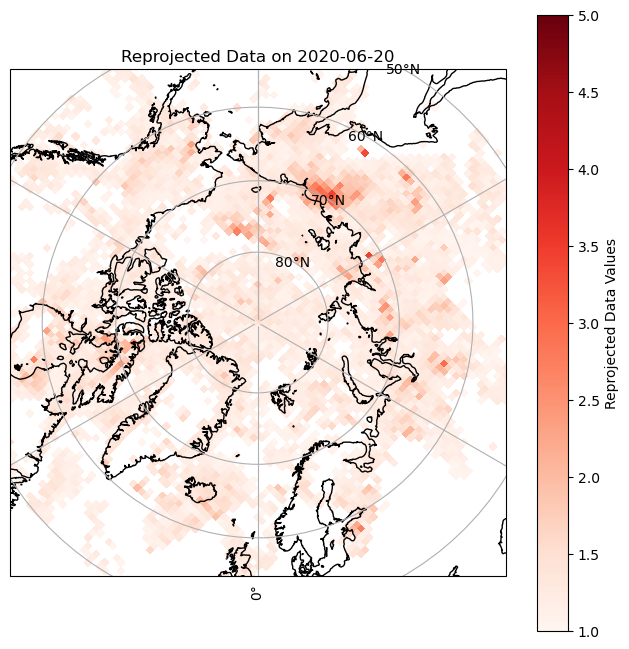

In [17]:
# Define the date, colormap, and value range you want to plot
date_to_plot = '2020-06-20'  # Change this to the desired date
colormap = 'Reds'  # Change this to the desired colormap
vmin = 1  # Change this to the desired minimum value
vmax = 5 # Change this to the desired maximum value

# Call the plotting function with the specified parameters
plot_reprojected_data(reprojected_datasets, area_def, plot_date=date_to_plot, cmap=colormap, vmin=vmin, vmax=vmax)


In [12]:
# Plot daily averages
#plot_daily_averages(reprojected_datasets)

In [13]:
# After generating reprojected_datasets_aerosol
import pickle

with open('reprojected_datasets_aai.pkl', 'wb') as f:
    pickle.dump(reprojected_datasets, f)

In [ ]:

# Load aerosol index data
with open('reprojected_datasets_aai.pkl', 'rb') as f:
    reprojected_datasets_aerosol = pickle.load(f)

# Load carbon monoxide data
with open('reprojected_datasets_co.pkl', 'rb') as f:
    reprojected_datasets_co = pickle.load(f)


import numpy as np
from netCDF4 import Dataset

def save_to_netcdf(reprojected_datasets_aerosol, reprojected_datasets_co, area_def, file_name):
    with Dataset(file_name, 'w', format='NETCDF4') as ncfile:
        # Create dimensions
        sample_date = next(iter(reprojected_datasets_aerosol))
        sample_data = reprojected_datasets_aerosol[sample_date]
        lat_dim = ncfile.createDimension('lat', sample_data['lats_new'].shape[0])
        lon_dim = ncfile.createDimension('lon', sample_data['lons_new'].shape[1])
        x_dim = ncfile.createDimension('x', area_def.width)
        y_dim = ncfile.createDimension('y', area_def.height)
        
        # Create variables for coordinates
        lats_var = ncfile.createVariable('latitude', np.float32, ('y', 'x'))
        lons_var = ncfile.createVariable('longitude', np.float32, ('y', 'x'))
        x_var = ncfile.createVariable('x', np.float32, ('x',))
        y_var = ncfile.createVariable('y', np.float32, ('y',))
        
        # Write latitude and longitude data
        lats_var[:, :] = sample_data['lats_new']
        lons_var[:, :] = sample_data['lons_new']
        
        # Write x and y coordinate data
        x_var[:] = np.linspace(area_def.area_extent[0], area_def.area_extent[2], area_def.width)
        y_var[:] = np.linspace(area_def.area_extent[1], area_def.area_extent[3], area_def.height)
        
        # Add attributes to coordinates
        lats_var.units = 'degrees_north'
        lons_var.units = 'degrees_east'
        x_var.units = 'meters'
        y_var.units = 'meters'
        
        # Create CRS variable
        crs = ncfile.createVariable('crs', 'i4')
        crs.spatial_ref = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +datum=WGS84 +units=m +no_defs'
        crs.grid_mapping_name = 'polar_stereographic'
        crs.straight_vertical_longitude_from_pole = -45.0
        crs.latitude_of_projection_origin = 90.0
        crs.standard_parallel = 70.0
        crs.false_easting = 0.0
        crs.false_northing = 0.0
        
        # Add aerosol index data
        for date, data in reprojected_datasets_aerosol.items():
            data_var = ncfile.createVariable(f'aerosol_index_{date}', np.float32, ('y', 'x',), zlib=True)
            data_var[:, :] = data['reprojected_data']
            data_var.units = 'aerosol_index'
            data_var.coordinates = 'latitude longitude'
            data_var.grid_mapping = 'crs'
        
        # Add carbon monoxide data
        for date, data in reprojected_datasets_co.items():
            data_var = ncfile.createVariable(f'carbon_monoxide_{date}', np.float32, ('y', 'x',), zlib=True)
            data_var[:, :] = data['reprojected_data']
            data_var.units = 'mol/m^2'
            data_var.coordinates = 'latitude longitude'
            data_var.grid_mapping = 'crs'

# Save to NetCDF
save_to_netcdf(reprojected_datasets_aerosol, reprojected_datasets_co, area_def, 'combined_output_1.nc')
